# Kex NIRS LUCAS | KSSL + miniai

In [1]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown install --upgrade --no-cache-dir gdown

# cd /root
# python
# import gdown
# Links: 
#   - VNIR LUCAS: "1OnwGgDqvjnDYEik14h_lSi83M4AwzYBt"
#   - VNIR KSSL: "17ZNSqsQi6PUeOLnUozq-C6Pj22dItm_Y"
# id = "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG" # MIRS KSSL v1 or "1SzQZqpbJuK3iCqjJYabuEobbgPXm3cHT" for v2
# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

In [2]:
#!pip install spanda

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import pandas as pd
from collections import namedtuple
from functools import partial

# from fastcore.foundation import L
# from fastcore.basics import risinstance
# import fastcore as fc
import fastcore.all as fc

# from fastai.vision.all import *
# from fastai.data.all import *
import torch
from torch import tensor, nn, optim
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.nn import init

from spanda.miniai.init import init_weights, GeneralRelu, BatchTransformCB
from spanda.miniai.activations import ActivationStats
from spanda.miniai.sgd import BatchSchedCB
from spanda.miniai.learner import (Learner, TrainCB, DeviceCB,
                                   ProgressCB, MetricsCB, SingleBatchCB)

from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

/Users/franckalbinet/mambaforge/envs/spanda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configs

In [5]:
is_local = True
root_dir = Path('../../_data/') if is_local else Path('.')

## Utils

In [6]:
def meet_criteria(src_dir, analyte='725'):
    has_spectrum = len(fc.L(fname for fname in src_dir.ls() if fname.name != 'target.csv')) > 0
    y_in_range = (pd.read_csv(src_dir / 'target.csv', 
                              dtype={'analyte': str, 'value': float},
                              index_col='analyte').loc[analyte] > 0).value
    return has_spectrum and y_in_range

In [7]:
get_spectra = lambda o: fc.L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

In [8]:
def get_paths(src_dir, analytes=['725']):     
    path = Path(src_dir)
    
    # Only samples with spectra
    paths = [p for p in tqdm(path.ls()) if len(p.ls()) > 1]
    
    # Only strictly positive measurements
    paths = [p for p in tqdm(paths) if AnalytesTfm(analytes=analytes)(get_target(p)) > 0] 
    
    return fc.L(paths)

In [9]:
def get_x(src_dir, index='wavelength'):
    fnames = fc.L(fname for fname in src_dir.ls() if fname.name != 'target.csv')
    dfs = (pd.read_csv(fname, index_col=index) for fname in fnames)
    df = pd.concat(dfs, axis=1, ignore_index=False)
    return torch.tensor(df.values, dtype=torch.float).T

def get_y(src_dir, analytes=None):
    df = pd.read_csv(src_dir / 'target.csv', dtype={'analyte': str, 'value': float})
    if analytes: df = df[df.analyte.isin(analytes)]
    return torch.tensor(df['value'].values, dtype=torch.float)

# item transforms
class AvgTfm:
    def __init__(self, weighted=False):
        self.weighted = weighted
        
    def __call__(self, x): 
        if self.weighted:
            return self._weights(len(x))@x
        else:
            return torch.mean(x, dim=0, keepdim=True)
    
    def _weights(self, n):
        weights = torch.rand(n)
        return (weights/weights.sum()).unsqueeze(dim=0).to(device)
 
# batch transforms
def _snv(b):
    x, y = b
    mean, std = torch.mean(x, dim=2, keepdim=True), torch.std(x, dim=2, keepdim=True)
    return ((x - mean)/std), y

def _log10(b):
    x, y = b
    return x, torch.log10(y)

class SpecDataset(Dataset):
    def __init__(self, src_dirs, get_x, get_y, transform=None, target_transform=None):
        self.src_dirs = src_dirs
        self.transform = transform
        self.target_transform = target_transform
        self.get_x = get_x
        self.get_y = get_y

    def __len__(self):
        return len(self.src_dirs)

    def __getitem__(self, idx):
        x, y =  (getter(self.src_dirs[idx]) for getter in [self.get_x, self.get_y])
        if self.transform: x = self.transform(x)
        if self.target_transform: y = self.target_transform(y)
        return x, y.squeeze()
    
def get_dls(train_ds, valid_ds, bs, **kwargs):
    Dataloaders = namedtuple('Dataloader', ['train', 'valid'])
    return Dataloaders(
        DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
        DataLoader(valid_ds, batch_size=bs*2, **kwargs)) 

In [10]:
current_date = lambda: datetime.now().date().isoformat()

## Data loading

In [11]:
analytes = ['725'] # Kex

In [12]:
paths = Path(root_dir / 'kssl-vnir').ls(); paths
paths_kssl = fc.L([path for path in tqdm(paths) if meet_criteria(path)]); paths_kssl

100%|██████████| 21004/21004 [00:13<00:00, 1506.75it/s]


(#20949) [Path('../../_data/kssl-vnir/163161'),Path('../../_data/kssl-vnir/110493'),Path('../../_data/kssl-vnir/97322'),Path('../../_data/kssl-vnir/166413'),Path('../../_data/kssl-vnir/92650'),Path('../../_data/kssl-vnir/47957'),Path('../../_data/kssl-vnir/170576'),Path('../../_data/kssl-vnir/120206'),Path('../../_data/kssl-vnir/42419'),Path('../../_data/kssl-vnir/78584')...]

In [13]:
paths = Path(root_dir / 'lucas-vnir').ls(); paths
paths_lucas = fc.L([path for path in tqdm(paths) if meet_criteria(path)]); paths_lucas

100%|██████████| 21782/21782 [00:13<00:00, 1604.84it/s]


(#21779) [Path('../../_data/lucas-vnir/28261972'),Path('../../_data/lucas-vnir/43443418'),Path('../../_data/lucas-vnir/42221892'),Path('../../_data/lucas-vnir/36742852'),Path('../../_data/lucas-vnir/45963284'),Path('../../_data/lucas-vnir/39082546'),Path('../../_data/lucas-vnir/54202132'),Path('../../_data/lucas-vnir/46821620'),Path('../../_data/lucas-vnir/33522030'),Path('../../_data/lucas-vnir/37362192')...]

In [14]:
paths_all = paths_kssl + paths_lucas; paths_all

(#42728) [Path('../../_data/kssl-vnir/163161'),Path('../../_data/kssl-vnir/110493'),Path('../../_data/kssl-vnir/97322'),Path('../../_data/kssl-vnir/166413'),Path('../../_data/kssl-vnir/92650'),Path('../../_data/kssl-vnir/47957'),Path('../../_data/kssl-vnir/170576'),Path('../../_data/kssl-vnir/120206'),Path('../../_data/kssl-vnir/42419'),Path('../../_data/kssl-vnir/78584')...]

In [20]:
paths_train, paths_valid = train_test_split(paths_kssl, test_size=0.2, random_state=41)

train_ds, valid_ds = [SpecDataset(paths, 
                                  get_x=get_x,
                                  get_y=partial(get_y, analytes=['725']),
                                  transform=AvgTfm())
                      for paths in [paths_train, paths_valid]]

n_features = train_ds[0][0].shape[-1]

dls = get_dls(train_ds, valid_ds, bs=16, num_workers=8)

In [21]:
next(iter(dls.train))[0].shape

torch.Size([16, 1, 1951])

## Train & evaluate

### Models

In [214]:
x_in = torch.rand(10, 5, 1800)*10 + 20; x_in.shape

torch.Size([10, 5, 1800])

In [212]:
x_out = nn.BatchNorm1d(5)(x_in); x_out.shape

torch.Size([10, 5, 1800])

In [213]:
x_out.mean()

tensor(2.9110e-07, grad_fn=<MeanBackward0>)

In [216]:
x_out = nn.LayerNorm(1800)(x_in); x_out.shape

torch.Size([10, 5, 1800])

In [72]:
def conv(ni, nf, ks=5, stride=4, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv1d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [105]:
def get_single_linear_model(n_in): 
    return nn.Sequential(nn.Linear(n_in, 1, bias=True), nn.Flatten(0,-1))

In [107]:
def get_2_layer_linear_model(n_in): 
    return nn.Sequential(nn.Linear(n_in, 20, bias=True),
                         nn.Linear(20, 1, bias=True),
                         nn.Flatten(0,-1))

In [125]:
def get_shallow(n_in): 
    return nn.Sequential(nn.Linear(n_in, 20, bias=True),
                         nn.ReLU(),
                         nn.Linear(20, 1, bias=True),
                         nn.Flatten(0,-1))

In [ ]:
astats.plot_stats()

In [149]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm1d):
    layers = [conv(1, 8, ks=3, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], ks=5, stride=4, act=act, norm=norm) for i in range(len(nfs)-1)]
    # return nn.Sequential(*layers, nn.AdaptiveAvgPool1d(1),nn.Flatten(),
    # return nn.Sequential(*layers,nn.Flatten(),
    #                      nn.Linear(2*nfs[-1], 10, bias=True), 
    #                      nn.Linear(10, 1, bias=False),
    #                      nn.Flatten(0,-1))
    return nn.Sequential(*layers, nn.AdaptiveAvgPool1d(1), nn.Flatten(),
                        #  nn.Dropout(p=0.5),
                         nn.Linear(nfs[-1], 1, bias=False), 
                         nn.Flatten(0,-1))
    # return nn.Sequential(*layers)

In [88]:
model = get_single_linear_model(n_features)

In [26]:
model = get_model()
model(next(iter(dls.train))[0]).shape

torch.Size([128])

In [27]:
# m = next(iter(dls.train))[0].shape[-1]  

# def get_model(m, nh=100): 
#     return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,nh//2), nn.ReLU(),
#                          nn.Linear(nh//2,1), nn.Flatten(0,-1))



In [28]:
# fc.filter_ex(model.modules(), fc.risinstance(nn.Conv2d))
# for m in model.modules(): print(m)

In [29]:
# fc.filter_ex(model.modules(), fc.risinstance(nn.Conv1d))

In [30]:
# def append_stats(hook, mod, inp, outp):
#     if not hasattr(hook,'stats'): hook.stats = ([],[])
#     acts = to_cpu(outp)
#     hook.stats[0].append(acts.mean())
#     hook.stats[1].append(acts.std())

### Train shalllow networks

#### Single layer

In [89]:
# Fitting
epochs = 20
lr = 1e-3

#act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
#iw = partial(init_weights, leaky=0.1)
model = get_single_linear_model(n_features)
#model.apply(init_weights)
metrics = MetricsCB(r2=R2Score())

snvX = BatchTransformCB(_snv)
logY = BatchTransformCB(_log10)

cbs = [DeviceCB(), snvX, logY, TrainCB(), metrics]

learn = Learner(model, dls, nn.MSELoss(), lr=2e-2, cbs=cbs, opt_func=optim.AdamW)

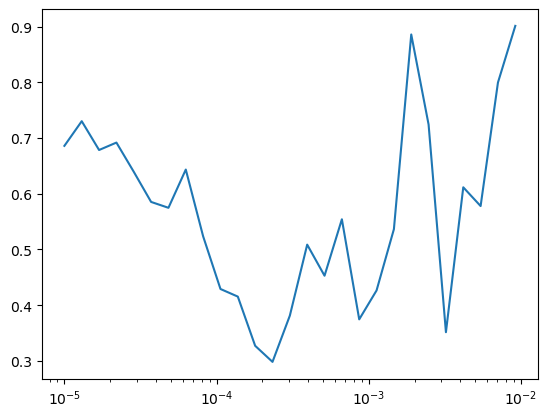

In [90]:
learn.lr_find()

In [100]:
# Fitting
epochs = 20
lr = 1e-4

#act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
#iw = partial(init_weights, leaky=0.1)
model = get_single_linear_model(n_features)
#model.apply(init_weights)
metrics = MetricsCB(r2=R2Score())

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]

astats = ActivationStats()
snvX = BatchTransformCB(_snv)
logY = BatchTransformCB(_log10)
cbs = [DeviceCB(), snvX, logY, TrainCB(), 
       metrics, ProgressCB(plot=False), astats]

learn = Learner(model, dls, nn.MSELoss(), lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)

In [101]:
learn.fit(epochs)

r2,loss,epoch,train
-0.459,0.347,0,train
-0.102,0.271,0,eval
-0.035,0.246,1,train
0.013,0.242,1,eval
0.049,0.226,2,train
0.088,0.224,2,eval
0.112,0.211,3,train
0.115,0.217,3,eval
0.162,0.199,4,train
0.199,0.197,4,eval


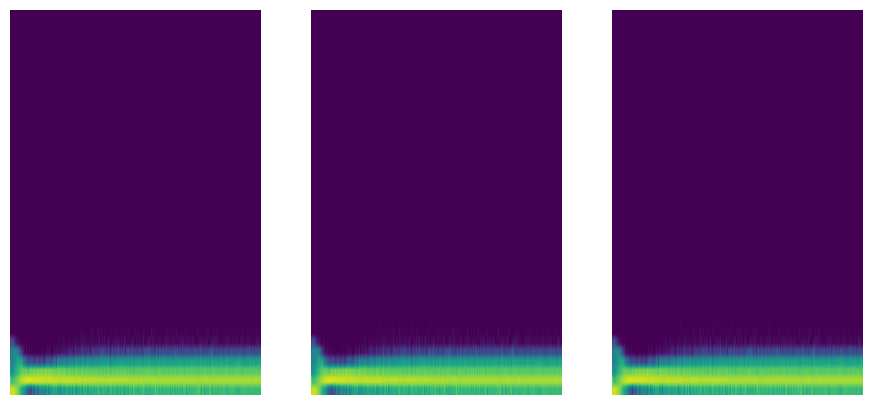

In [102]:
astats.color_dim(aspect='auto')

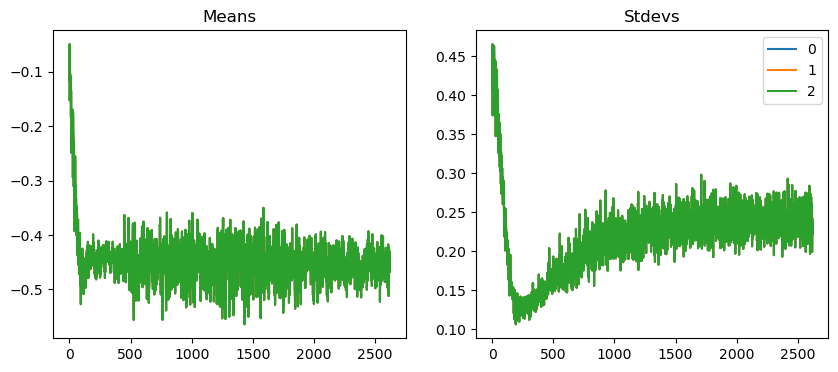

In [103]:
astats.plot_stats()

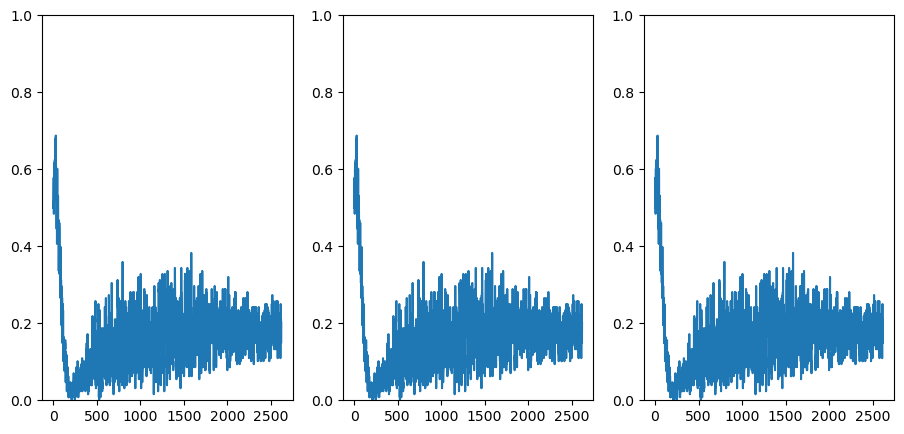

In [104]:
astats.dead_chart()

#### Two linear layers (10, 20)

In [108]:
# Fitting
epochs = 20
lr = 1e-3

#act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
#iw = partial(init_weights, leaky=0.1)
model = get_2_layer_linear_model(n_features)
#model.apply(init_weights)
metrics = MetricsCB(r2=R2Score())

snvX = BatchTransformCB(_snv)
logY = BatchTransformCB(_log10)

cbs = [DeviceCB(), snvX, logY, TrainCB(), metrics]

learn = Learner(model, dls, nn.MSELoss(), lr=2e-2, cbs=cbs, opt_func=optim.AdamW)

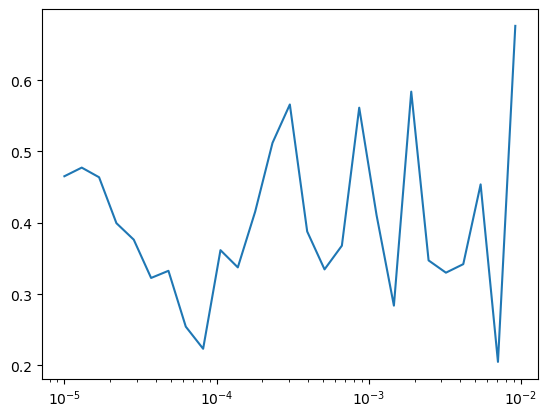

In [109]:
learn.lr_find()

In [119]:
# Fitting
epochs = 10
lr = 1e-4

#act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
#iw = partial(init_weights, leaky=0.1)
model = get_2_layer_linear_model(n_features)
#model.apply(init_weights)
metrics = MetricsCB(r2=R2Score())

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]

astats = ActivationStats()
snvX = BatchTransformCB(_snv)
logY = BatchTransformCB(_log10)
cbs = [DeviceCB(), snvX, logY, TrainCB(), 
       metrics, ProgressCB(plot=False), astats]

learn = Learner(model, dls, nn.MSELoss(), lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)

In [120]:
learn.fit(epochs)

r2,loss,epoch,train
-0.220,0.290,0,train
0.009,0.243,0,eval
0.082,0.218,1,train
0.162,0.206,1,eval
0.191,0.192,2,train
0.243,0.186,2,eval
0.241,0.180,3,train
0.267,0.180,3,eval
0.262,0.175,4,train
0.273,0.179,4,eval


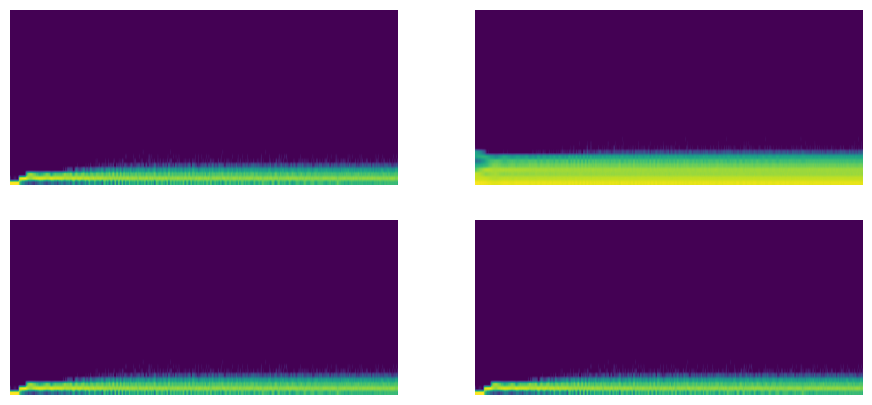

In [121]:
astats.color_dim(aspect='auto')

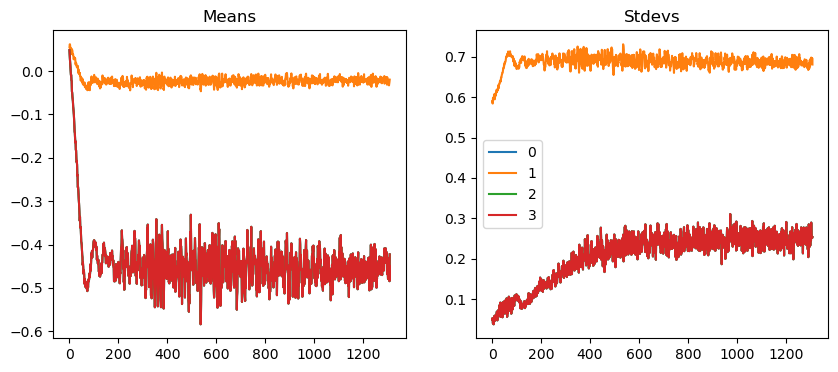

In [122]:
astats.plot_stats()

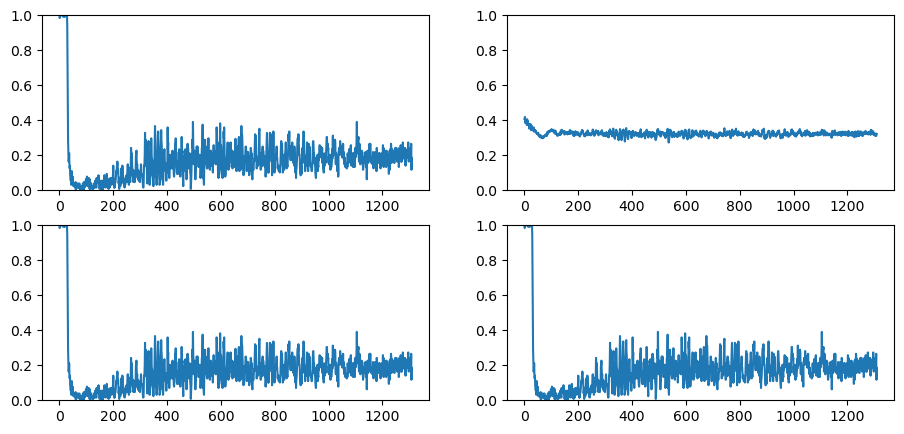

In [123]:
astats.dead_chart()

#### Two linear + relu layers (10, 20)

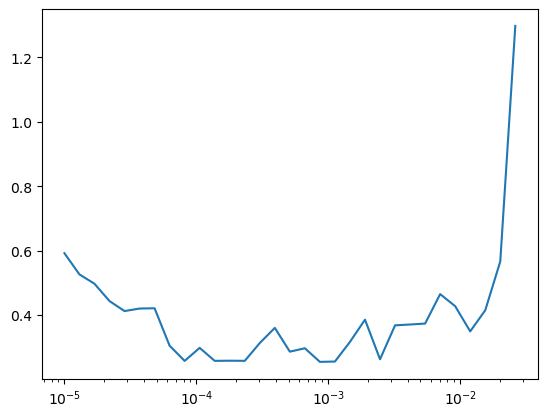

In [126]:
# Fitting
epochs = 20
lr = 1e-3

#act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
#iw = partial(init_weights, leaky=0.1)
model = get_shallow(n_features)
#model.apply(init_weights)
metrics = MetricsCB(r2=R2Score())

snvX = BatchTransformCB(_snv)
logY = BatchTransformCB(_log10)

cbs = [DeviceCB(), snvX, logY, TrainCB(), metrics]

learn = Learner(model, dls, nn.MSELoss(), lr=2e-2, cbs=cbs, opt_func=optim.AdamW)

learn.lr_find()

In [127]:
# Fitting
epochs = 10
lr = 1e-4

#act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0)
model = get_shallow(n_features)
model.apply(init_weights)
metrics = MetricsCB(r2=R2Score())

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]

astats = ActivationStats()
snvX = BatchTransformCB(_snv)
logY = BatchTransformCB(_log10)
cbs = [DeviceCB(), snvX, logY, TrainCB(), 
       metrics, ProgressCB(plot=False), astats]

learn = Learner(model, dls, nn.MSELoss(), lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)

In [128]:
learn.fit(epochs)

r2,loss,epoch,train
-0.066,0.253,0,train
0.103,0.220,0,eval
0.176,0.196,1,train
0.222,0.191,1,eval
0.256,0.177,2,train
0.285,0.176,2,eval
0.282,0.171,3,train
0.309,0.170,3,eval
0.299,0.167,4,train
0.294,0.174,4,eval


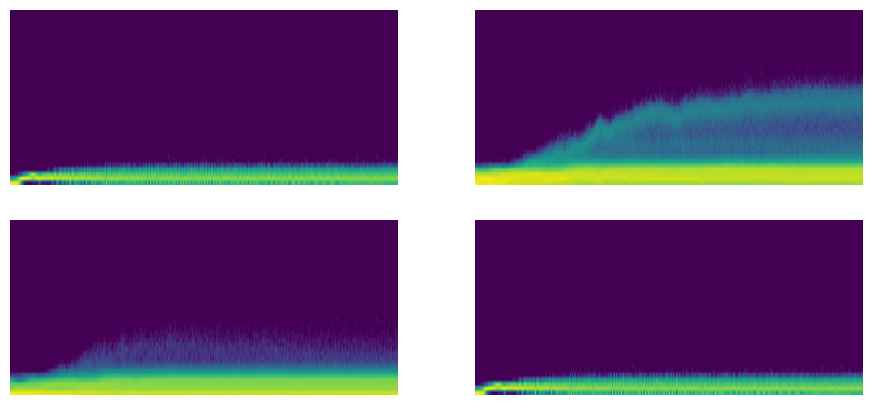

In [129]:
astats.color_dim(aspect='auto')

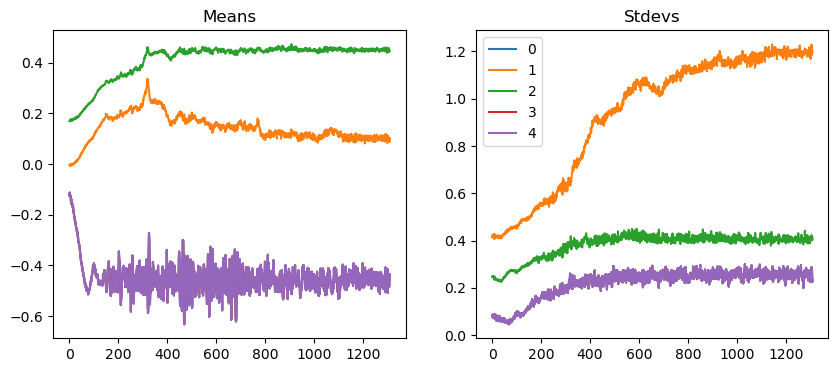

In [131]:
astats.plot_stats()

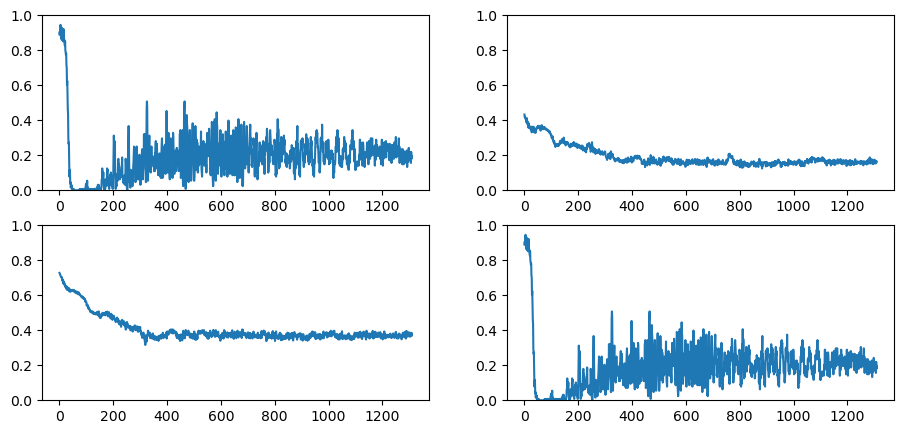

In [130]:
astats.dead_chart()

### Train Convnet

In [158]:
# Fitting
epochs = 20
lr = 1e-3

# act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
# iw = partial(init_weights, leaky=0.1)

act_gr = partial(nn.LeakyReLU, negative_slope=0.01)
iw = partial(init_weights, leaky=0.01)
iw = init_weights

model = get_model(act=act_gr)
model.apply(init_weights)
metrics = MetricsCB(r2=R2Score())

snvX = BatchTransformCB(_snv)
logY = BatchTransformCB(_log10)

cbs = [DeviceCB(), snvX, logY, TrainCB(), metrics]

learn = Learner(model, dls, nn.MSELoss(), lr=2e-2, cbs=cbs, opt_func=optim.AdamW)

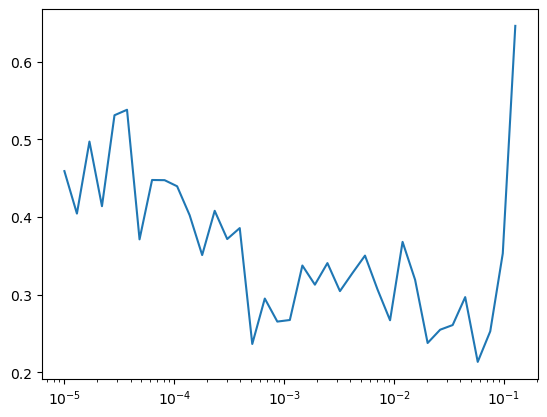

In [151]:
learn.lr_find()

In [223]:
# Fitting
epochs = 20
lr = 5e-3

act_gr = partial(nn.LeakyReLU, negative_slope=0.01)
iw = partial(init_weights, leaky=0.01)
iw = init_weights


model = get_model(act=act_gr)
model.apply(init_weights)

metrics = MetricsCB(r2=R2Score())

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]

# astats = ActivationStats(fc.risinstance(nn.Conv1d))
astats = ActivationStats(fc.risinstance(nn.BatchNorm1d))


snvX = BatchTransformCB(_snv)
logY = BatchTransformCB(_log10)

cbs = [DeviceCB(), snvX, logY, TrainCB(), 
       metrics, ProgressCB(plot=False), astats]

learn = Learner(model, dls, nn.MSELoss(), lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)

In [224]:
learn.fit(epochs)

r2,loss,epoch,train
-0.088,0.259,0,train
0.326,0.166,0,eval
0.199,0.191,1,train
0.351,0.159,1,eval
0.317,0.162,2,train
0.365,0.156,2,eval
0.336,0.158,3,train
0.368,0.155,3,eval
0.335,0.158,4,train
0.372,0.154,4,eval


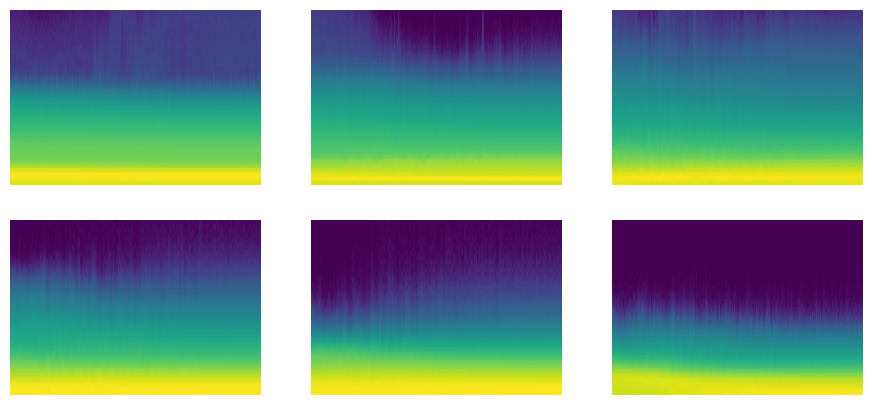

In [225]:
astats.color_dim(aspect='auto')

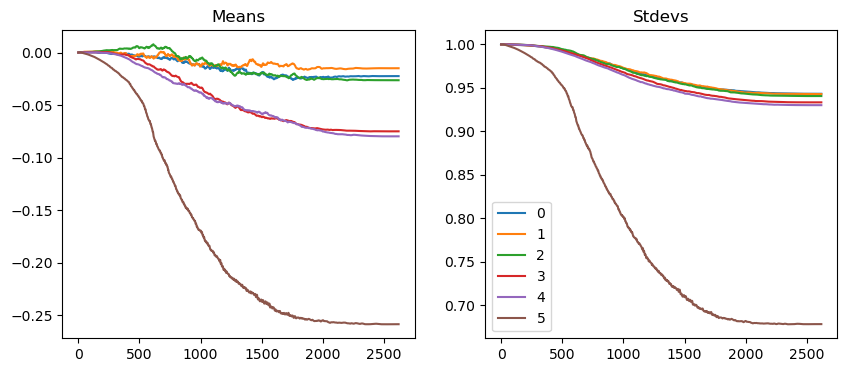

In [226]:
astats.plot_stats()

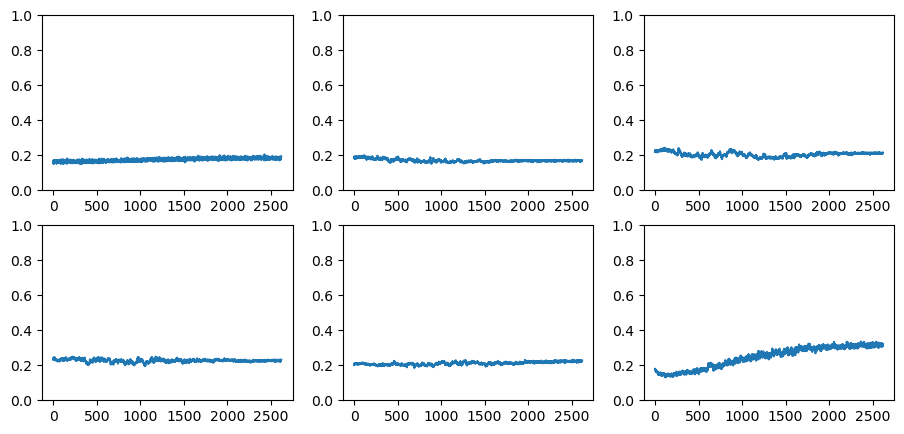

In [227]:
astats.dead_chart()